# CMIP6 Historical Prediction

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import pickle

In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

c:\Users\marti\Desktop\data\hw_extra


## Load cmip6 drivers

In [3]:
import tensorflow as tf
import os
import numpy as np
import random
import keras
SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    keras.utils.set_random_seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, GRU, Conv1D, Flatten, Reshape
import sys


In [4]:
from Predictions import (
    PredictionModel,
    SERA,
)
from indices import get_heatwaves_indices, transform_time_label

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load Data

In [5]:
path_drivers = "data/03_primary/drivers/dfs_dict.pickle"
with open(path_drivers, 'rb') as handle:
    models_df = pickle.load(handle)

In [9]:
hws_chile = pd.read_csv("data/local_data/monthly/hws_chile_library.csv")

hws_chile["time"] = pd.to_datetime(hws_chile["Unnamed: 0"],format='%Y-%m')
hws_chile.set_index('time', inplace=True)
hws_chile.drop(columns="Unnamed: 0", inplace=True)
hws_chile

hwn  hwf  hwd       hwm       hwa  hwmd    hwanom      hwmi
time                                                                   
1971-01-01  0.0  0.0  0.0  0.000000  0.000000   0.0  0.000000  0.000000
1971-02-01  0.2  0.7  0.7  0.447148  0.807169   0.7  1.508644  2.778778
1971-03-01  0.0  0.0  0.0  0.000000  0.000000   0.0  0.000000  0.000000
1971-04-01  0.2  0.6  0.6  0.637038  0.982249   0.6  1.911113  2.946747
1971-05-01  0.1  0.3  0.3  0.555671  0.901254   0.3  1.667013  2.703762
...         ...  ...  ...       ...       ...   ...       ...       ...
2023-08-01  0.3  1.0  1.0  0.902918  1.456688   1.0  2.786501  4.517084
2023-09-01  0.0  0.0  0.0  0.000000  0.000000   0.0  0.000000  0.000000
2023-10-01  0.1  0.3  0.3  0.062737  0.077569   0.3  0.188212  0.232706
2023-11-01  0.0  0.0  0.0  0.000000  0.000000   0.0  0.000000  0.000000
2023-12-01  0.1  0.6  0.6  0.077252  0.163605   0.6  0.463513  0.981629

[636 rows x 8 columns]

In [10]:
era5_df = pd.concat((models_df["ERA5"],hws_chile),axis=1)
era5_df

nino12    nino34  anom_wind_cl_raco  anom_wind_cl_puelche   
time                                                                      
1971-01-01 -1.928113 -1.640253           0.006237              1.624297  \
1971-02-01 -2.979414 -1.713375          -0.288501              0.221068   
1971-03-01 -3.288180 -2.059431          -0.232439              0.302271   
1971-04-01 -2.543985 -2.459558          -0.485039             -0.753484   
1971-05-01 -1.714362 -2.507134          -0.089548              0.699281   
...              ...       ...                ...                   ...   
2023-08-01  2.723302  1.550383           1.282423              1.932909   
2023-09-01  2.123090  1.722627           0.850378              1.987928   
2023-10-01  1.840521  1.741871          -0.057451             -0.161683   
2023-11-01  1.625754  1.960339           0.096582              1.173807   
2023-12-01  1.109014  2.099410          -0.348814             -1.820655   

            anom_wind_pressure  anom_ta_cl  anom_pdo  anom_psl_sam_40   
time                                                                    
1971-01-01         -155.360306    1.249381  0.997573      -112.387703  \
1971-02-01          -98.484497   -0.026722  0.767220        57.690361   
1971-03-01          -77.386848   -0.150289  0.633572         6.743707   
1971-04-01          198.601791   -0.788936  0.562198       -70.511070   
1971-05-01          185.134171    0.501217  0.420079      -178.369583   
...                        ...         ...       ...              ...   
2023-08-01         -374.929413    2.065721  1.704082       -33.429050   
2023-09-01         -178.303970    1.922226  2.295783        29.182522   
2023-10-01           24.046869   -0.402164  2.689852       312.206818   
2023-11-01         -339.330139    0.945060  2.757317       124.789513   
2023-12-01          303.737122   -1.503564  2.452650       269.578552   

            anom_psl_sam_65  anom_dmi_east  ...  adv_blob  adv_chile  hwn   
time                                        ...                             
1971-01-01       341.377930       0.051705  ... -1.075192   5.139239  0.0  \
1971-02-01        51.769032      -0.038294  ...  0.878110   0.437056  0.2   
1971-03-01      -146.034164      -0.249040  ... -3.049048  -0.064510  0.0   
1971-04-01       233.869843      -0.472573  ...  0.137372  -0.576733  0.2   
1971-05-01       701.905396      -0.592277  ...  0.105984  -0.972252  0.1   
...                     ...            ...  ...       ...        ...  ...   
2023-08-01       154.142227       0.257379  ... -2.776886  -0.530017  0.3   
2023-09-01       252.867569       0.023470  ... -0.182294   3.426786  0.0   
2023-10-01      -144.109970      -0.294358  ... -1.519804  -1.120164  0.1   
2023-11-01        80.167175      -0.467022  ...  1.716634   1.758876  0.0   
2023-12-01      -609.298462      -0.471782  ... -0.719822  -0.454558  0.1   

            hwf  hwd       hwm       hwa  hwmd    hwanom      hwmi  
time                                                                
1971-01-01  0.0  0.0  0.000000  0.000000   0.0  0.000000  0.000000  
1971-02-01  0.7  0.7  0.447148  0.807169   0.7  1.508644  2.778778  
1971-03-01  0.0  0.0  0.000000  0.000000   0.0  0.000000  0.000000  
1971-04-01  0.6  0.6  0.637038  0.982249   0.6  1.911113  2.946747  
1971-05-01  0.3  0.3  0.555671  0.901254   0.3  1.667013  2.703762  
...         ...  ...       ...       ...   ...       ...       ...  
2023-08-01  1.0  1.0  0.902918  1.456688   1.0  2.786501  4.517084  
2023-09-01  0.0  0.0  0.000000  0.000000   0.0  0.000000  0.000000  
2023-10-01  0.3  0.3  0.062737  0.077569   0.3  0.188212  0.232706  
2023-11-01  0.0  0.0  0.000000  0.000000   0.0  0.000000  0.000000  
2023-12-01  0.6  0.6  0.077252  0.163605   0.6  0.463513  0.981629  

[636 rows x 25 columns]

## Predict by season

In [11]:
indices_of_interest = list(hws_chile.columns)
era5_trained_models = {}
bounds = (-1.1692892810242344, -0.30647585455315646, 3.0, 6.499969486244418)
loss_fn=SERA(bounds=bounds,T=100, initial_weight=0.1, fn="piecewise2")
models_predicted = {}
seasons_label_scalers = {}

for i in range(1,13):
    df_season = era5_df[era5_df.index.month==i]
    cnn_rnn_model = Sequential([
            Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(era5_df.columns) - len(indices_of_interest))),
            Reshape((1, 16)),  # Back to time dimension
            SimpleRNN(8, activation="tanh"),
            Dropout(0.1),
            Dense(len(indices_of_interest))
        ])
    pred = PredictionModel(df_season, i, indices_of_interest, cnn_rnn_model, name_regressor="CNNRNN16",loss_fn=loss_fn)
    seasons_label_scalers[i] = pred.label_scaler
    pred.compile_keras_model()
    
    y_train, y_pred_train = pred.train(5)
    for name, df in models_df.items():
        if i==1:
            models_predicted[name] = pd.DataFrame()
        df_target = df[df.index.month==i]
        df_target = df_target[(df_target.index.year >=1972) & (df_target.index.year <= 2014)]
        # df_target[indices_of_interest] = df_season[indices_of_interest]
        # Normalize cmip6 features for machine input
        target = pred.scaler_X.transform(df_target[pred.scaler_X.feature_names_in_])
        # Reshape for keras and predict
        predicted_normalized = pred.regressor.predict(pred.reshape_for_keras(target))
        # Transform back to original range
        predicted_real = pred.label_scaler.inverse_transform(predicted_normalized)
        predicted = pd.DataFrame(predicted_real).rename(columns={i: label for i,label in enumerate(indices_of_interest)})
        predicted["Date"] = df_target.index
        predicted.set_index("Date",inplace=True)
        models_predicted[name] = pd.concat((models_predicted[name],predicted),axis=0)
        


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 0s/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 0s/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 16ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 3ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 3ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 8ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 0s/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


2/2 [==============================] - 0s 2ms/step


In [12]:
temp_df = pd.DataFrame()
for name, df in models_predicted.items():
    temp_df = pd.concat((temp_df, df), axis=1)

models_predicted["mean"] = pd.DataFrame(columns=models_predicted["ERA5"].columns,index=df.index)
for col in np.unique(temp_df.columns):
    models_predicted["mean"][col] = temp_df[col].mean(axis=1)
models_predicted["mean"]

hwn       hwf       hwd       hwm       hwa      hwmd   
Date                                                                     
1972-01-01  0.344169  1.484588  0.828883  0.639140  0.786118  1.039912  \
1973-01-01  0.323962  1.705976  1.086970  0.737700  0.965331  1.179752   
1974-01-01  0.228388  1.353266  1.053341  0.547827  0.754777  0.963925   
1975-01-01  0.273777  1.175396  0.406682  0.395266  0.412665  0.820178   
1976-01-01  0.237119  0.875747  0.338921  0.278985  0.502194  0.868241   
...              ...       ...       ...       ...       ...       ...   
2010-12-01  0.178401  1.155340  0.659224  0.338114  0.870409  0.658122   
2011-12-01  0.314260  1.286006  1.074804  0.323504  0.884413  0.923138   
2012-12-01  0.245857  1.027127  0.891588  0.268551  0.898925  0.640285   
2013-12-01  0.376556  1.632468  0.856081  0.557369  0.955734  0.876151   
2014-12-01  0.264130  1.312638  0.776354  0.423800  0.970002  0.605444   

              hwanom      hwmi  
Date                            
1972-01-01  2.737153  4.684723  
1973-01-01  3.302591  4.388785  
1974-01-01  3.149879  4.663059  
1975-01-01  0.751738  2.932434  
1976-01-01 -0.439738  1.069625  
...              ...       ...  
2010-12-01  1.175734  2.236976  
2011-12-01  2.340045  3.073095  
2012-12-01  2.119730  2.428628  
2013-12-01  2.825075  4.676420  
2014-12-01  2.049588  3.419523  

[516 rows x 8 columns]

In [13]:
models_predicted["meteochile"] = era5_df[(era5_df.index.year >= 1972) & (era5_df.index.year <=2014)][indices_of_interest]

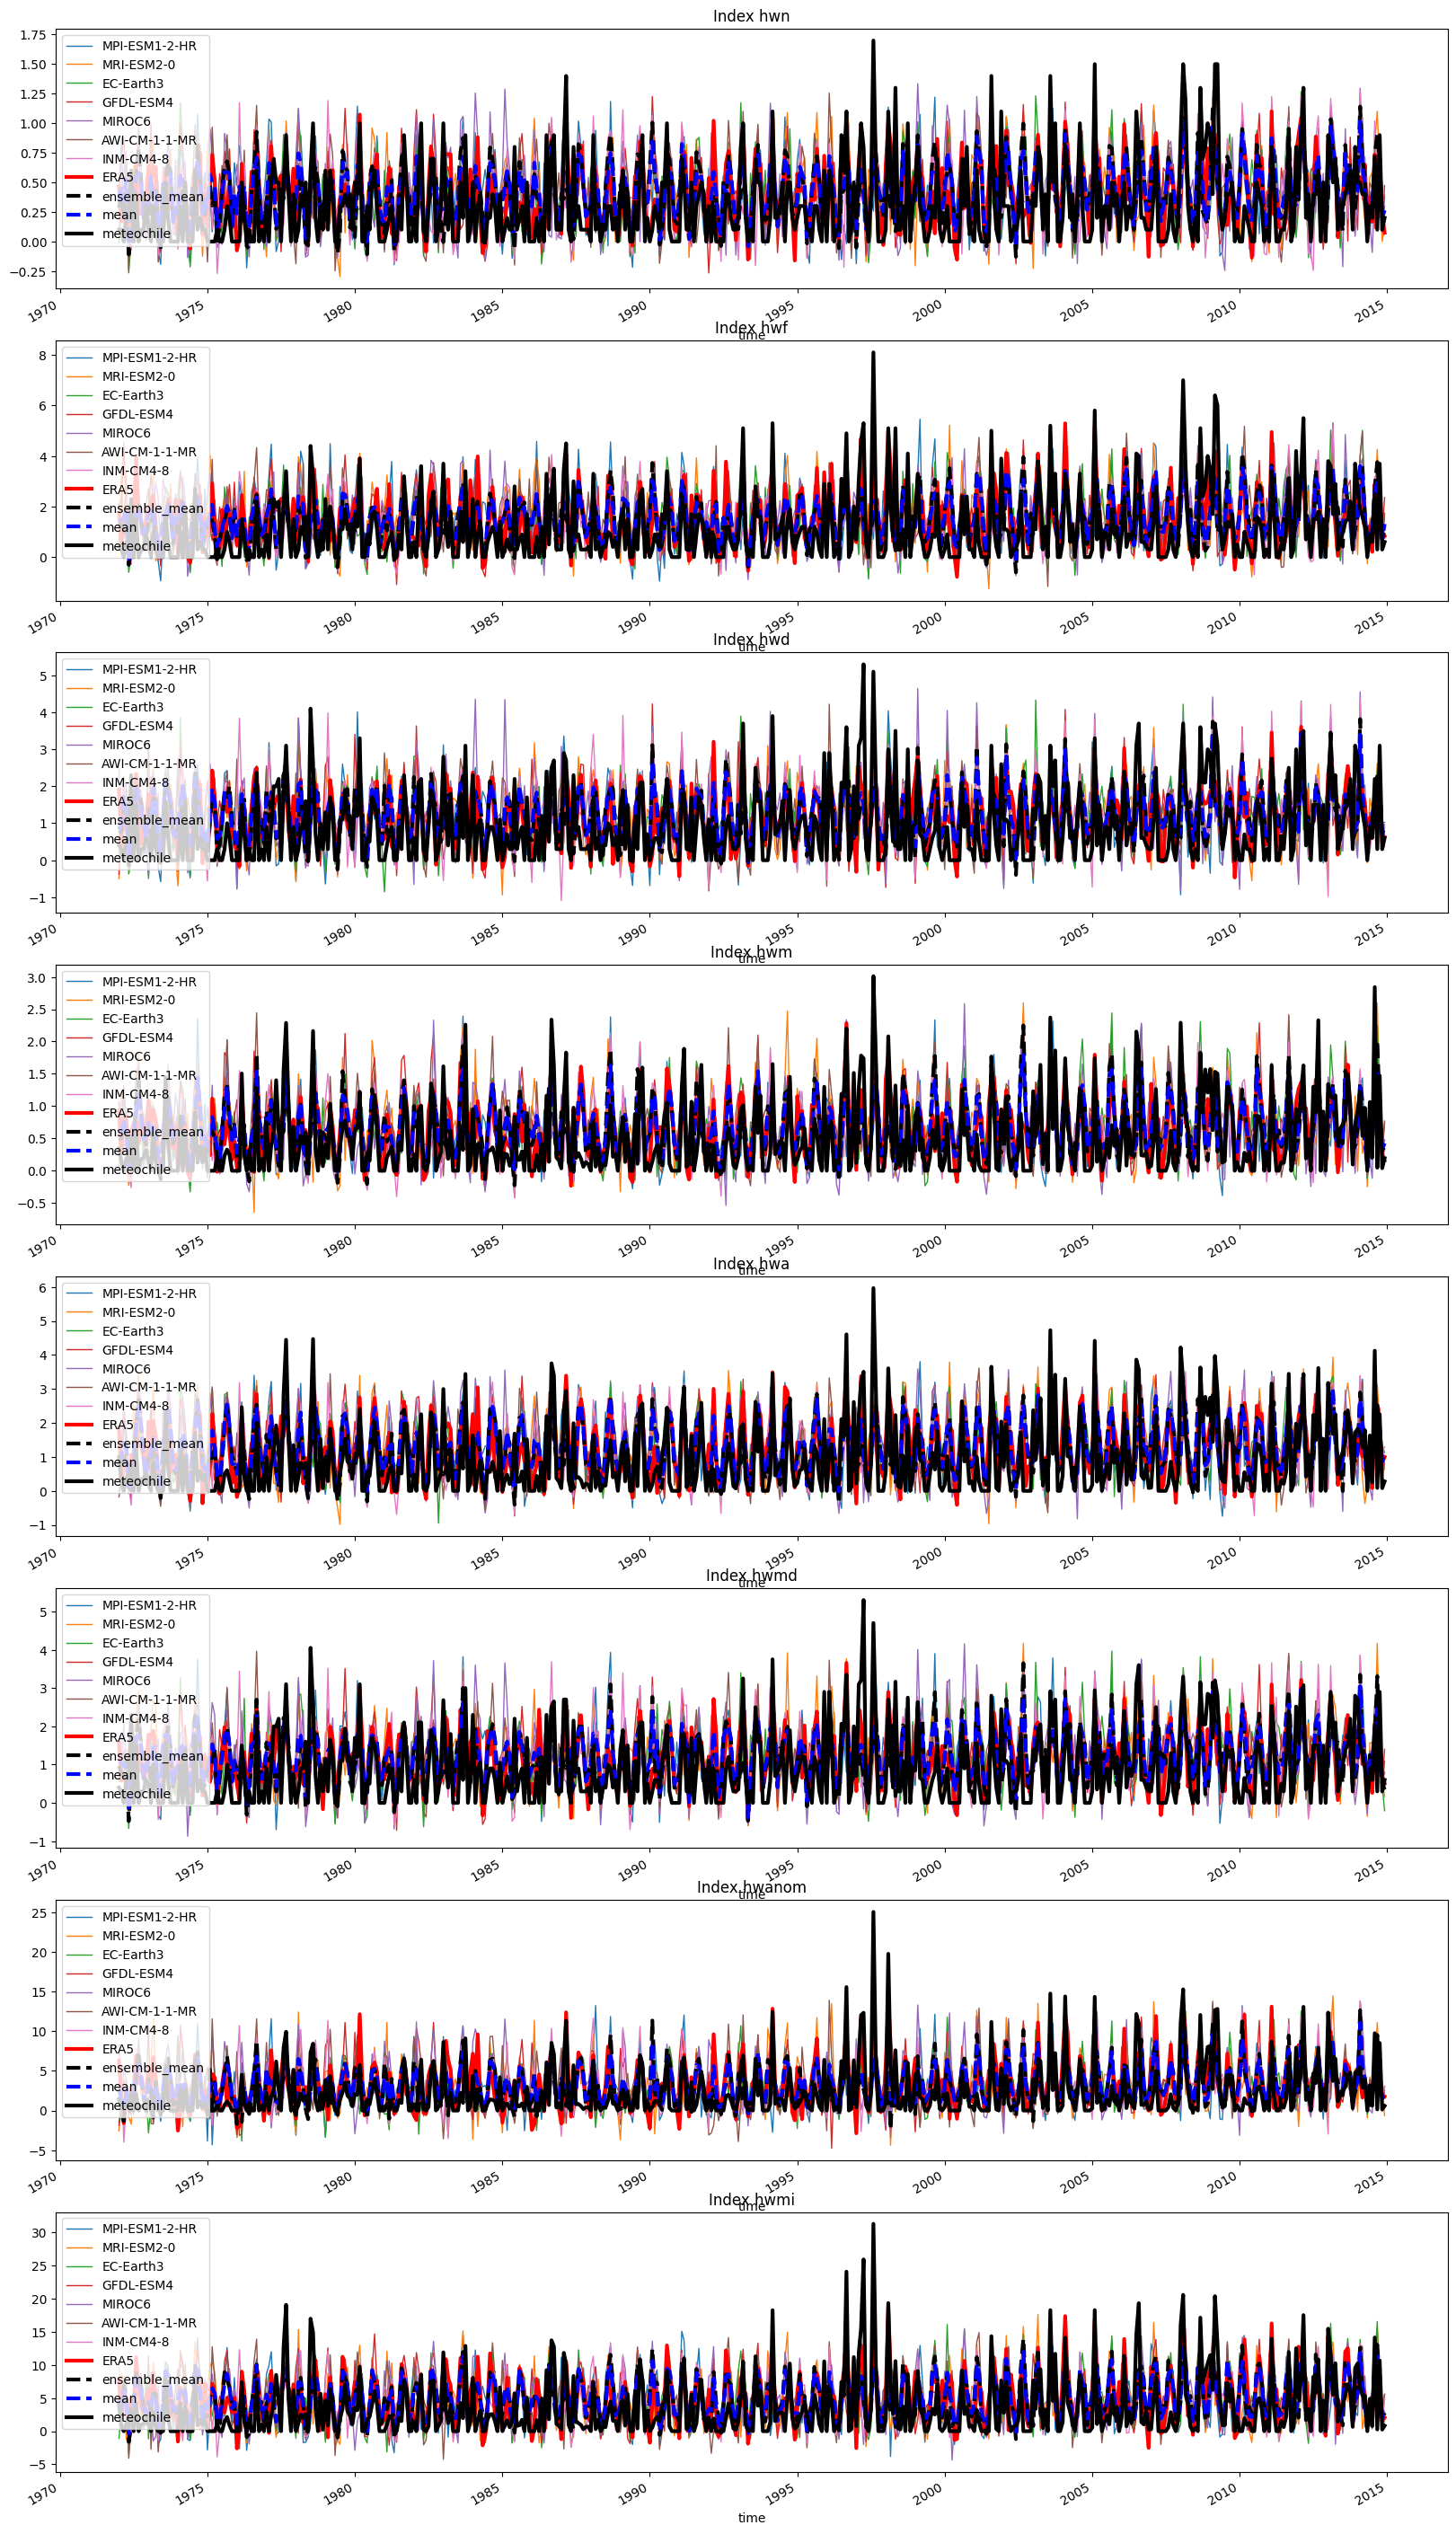

In [15]:
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 40))
for i, index in enumerate(indices_of_interest):
    for model_name in models_predicted.keys():
        if model_name == "meteochile":
            models_predicted[model_name].plot(y=index, ax=axs[i], lw=3, c="black", label="meteochile")
        elif model_name == "ERA5":
            models_predicted[model_name].plot(y=index, ax=axs[i], lw=3, c="red", label=model_name)
        elif model_name == "ensemble_mean":
            models_predicted[model_name].plot(y=index, ax=axs[i], lw=3, c="black", linestyle="--", label=model_name)
        elif model_name == "mean":
            models_predicted[model_name].plot(y=index, ax=axs[i], lw=3, c="blue", linestyle="--", label=model_name)
        else:
            models_predicted[model_name].plot(y=index, ax=axs[i], lw=1, label=model_name)
    axs[i].set_title(f"Index {index}")

In [16]:
models_predicted["mean"] = models_predicted["mean"].astype(np.float64)

In [ ]:
models_predicted_yearly = {}
models_predicted_decadal = {}

for name, df in models_predicted.items():

    models_predicted_yearly[name] = transform_time_label(df, "year")
    models_predicted_decadal[name] = transform_time_label(df, "decade")


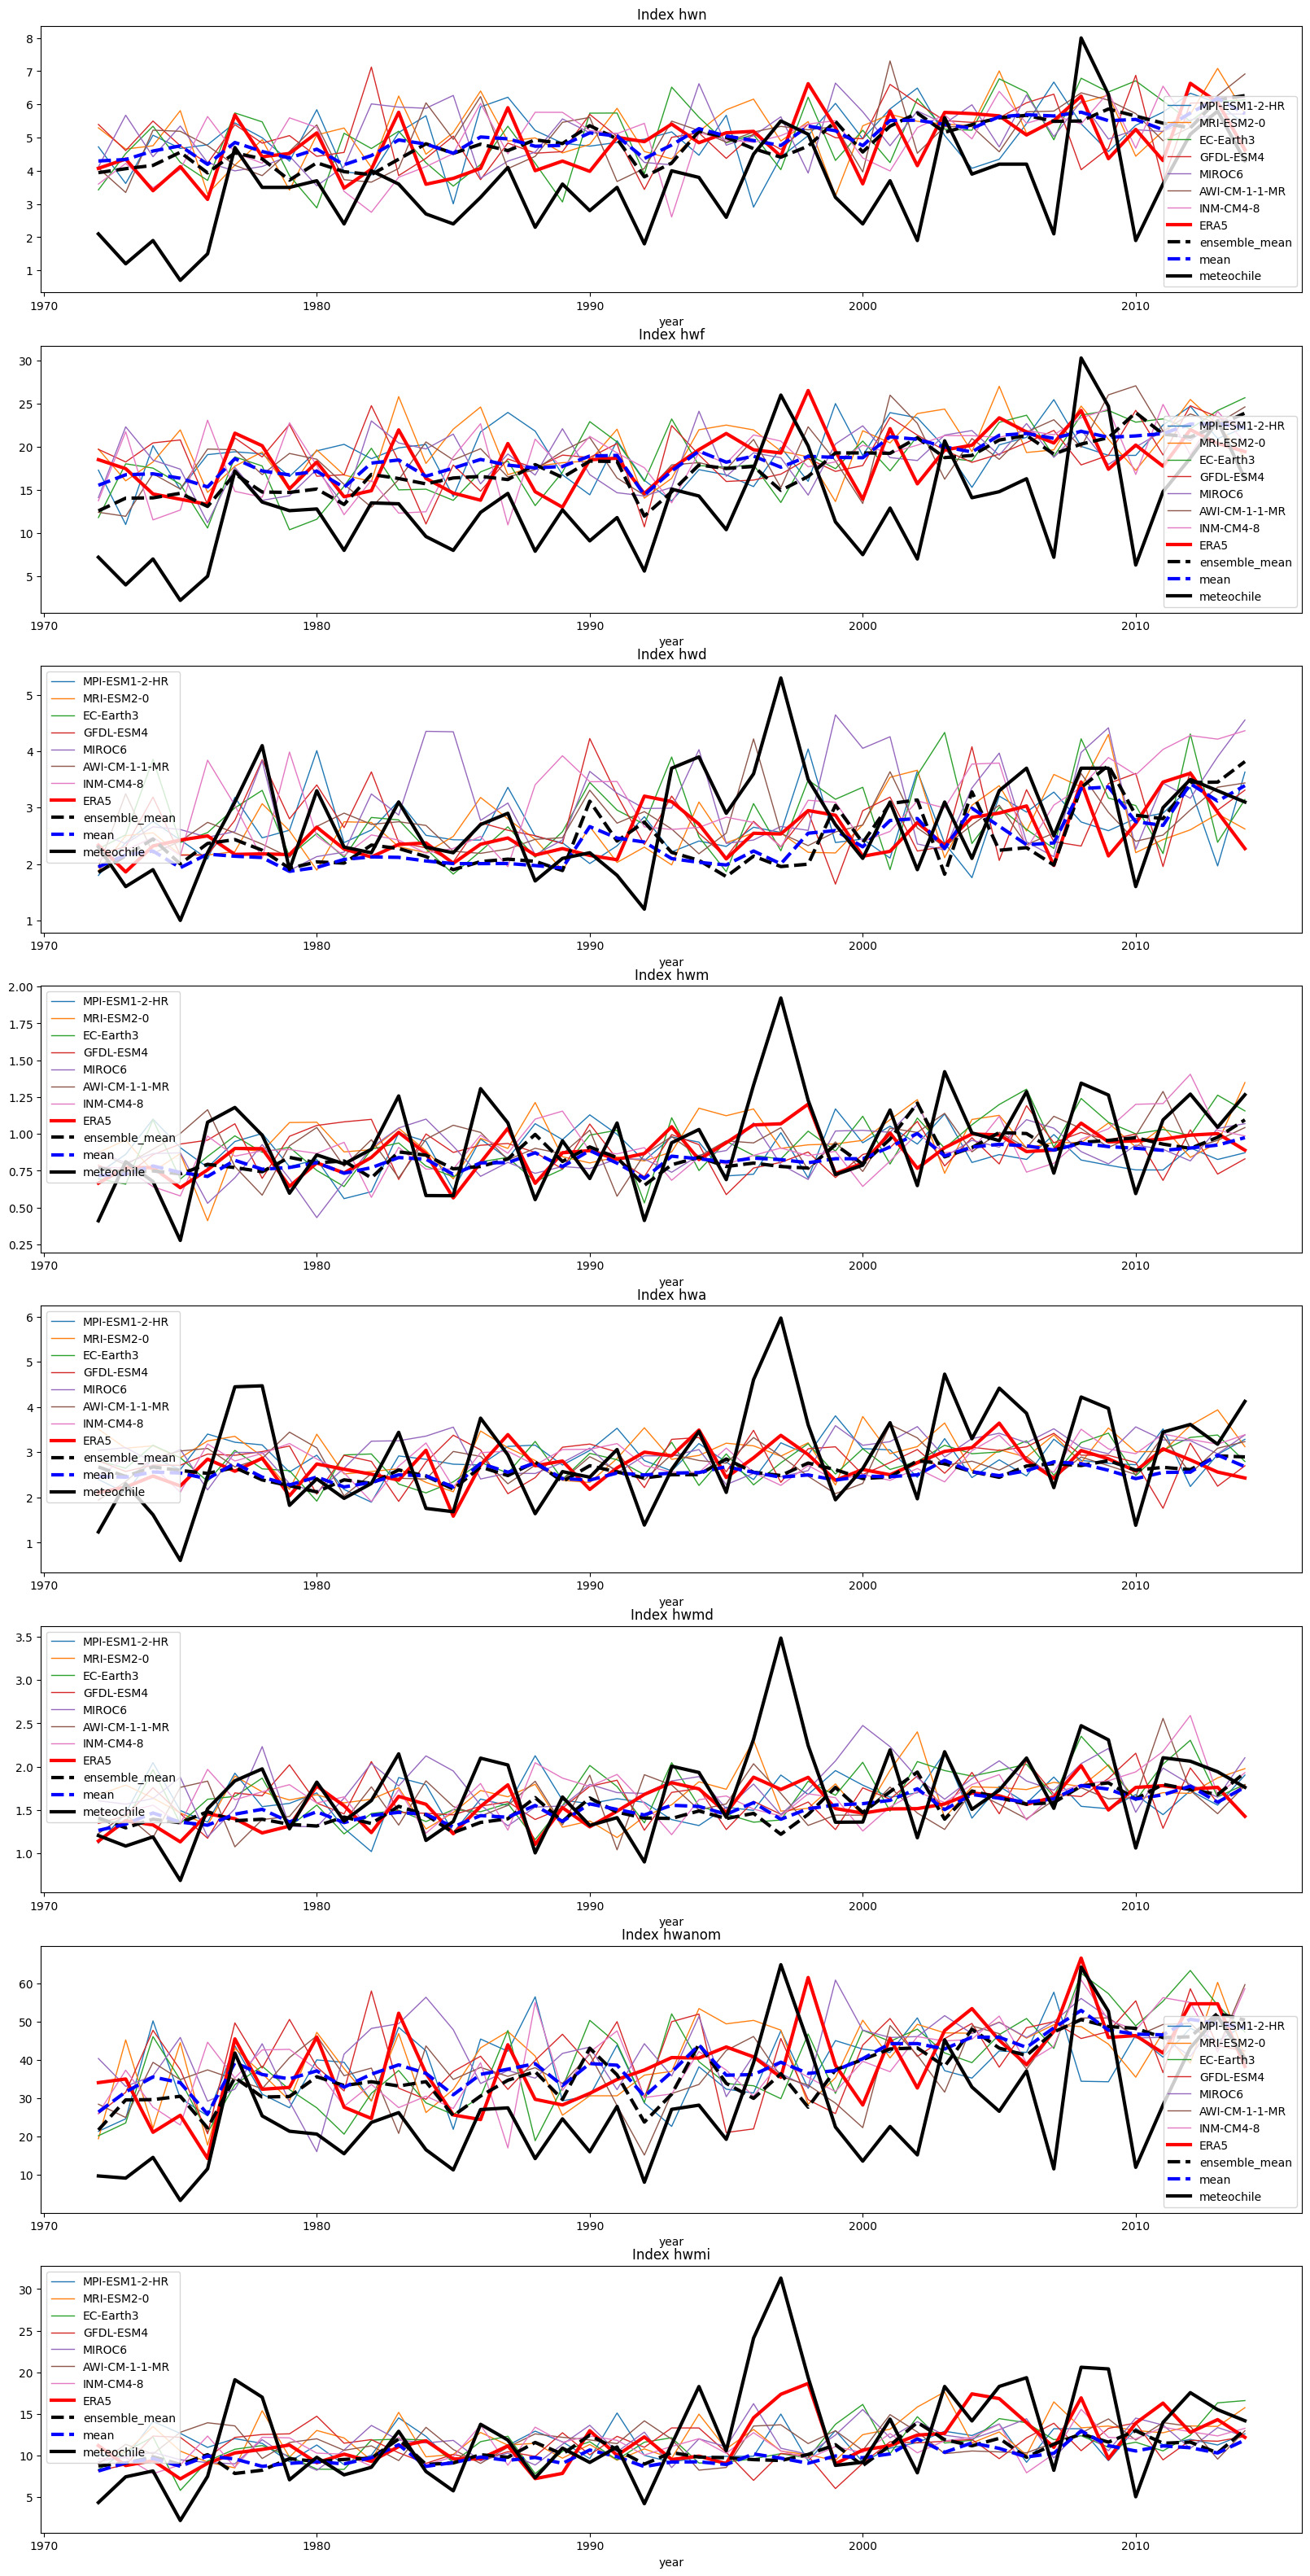

In [31]:
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 40))
for i, index in enumerate(indices_of_interest):
    for model_name in models_predicted_yearly.keys():
        if model_name == "meteochile":
            models_predicted_yearly[model_name].plot(y=index, ax=axs[i], lw=3, c="black", label="meteochile")
        elif model_name == "ERA5":
            models_predicted_yearly[model_name].plot(y=index, ax=axs[i], lw=3, c="red", label=model_name)
        elif model_name == "ensemble_mean":
            models_predicted_yearly[model_name].plot(y=index, ax=axs[i], lw=3, c="black", linestyle="--", label=model_name)
        elif model_name == "mean":
            models_predicted_yearly[model_name].plot(y=index, ax=axs[i], lw=3, c="blue", linestyle="--", label=model_name)
        else:
            models_predicted_yearly[model_name].plot(y=index, ax=axs[i], lw=1, label=model_name)
    axs[i].set_title(f"Index {index}")

In [47]:
def compare_relationships(models_dict):
    """
    Compare mathematical relationships between heatwave indices for each model.

    Parameters
    ----------
    models_dict : dict
        Dictionary of {model_name: dataframe} containing indices.

    Returns
    -------
    dict
        Dictionary {model_name: dataframe} with comparison results.
    """
    tol = 1e-12

    results = {}

    for model, df in models_dict.items():
        comp_df = pd.DataFrame(index=df.index)

        # Expected values
        exp_hwanom = df["hwm"] * df["hwf"]
        exp_hwmd   = df["hwf"] / df["hwn"]
        exp_hwmi   = df["hwd"] * df["hwa"]

        # Relative differences
        comp_df["rel_diff_hwanom"] = (df["hwanom"] - exp_hwanom) / (exp_hwanom + tol)
        comp_df["rel_diff_hwmd"]   = (df["hwmd"]   - exp_hwmd)   / (exp_hwmd   + tol)
        comp_df["rel_diff_hwmi"]   = (df["hwmi"]   - exp_hwmi)   / (exp_hwmi   + tol)

        # Inequalities → booleans
        comp_df["hwd_ge_hwmd"] = df["hwd"] >= df["hwmd"]
        comp_df["hwa_ge_hwm"]  = df["hwa"] >= df["hwm"]

        results[model] = comp_df

    return results


In [48]:
yearly_checks = compare_relationships(models_predicted_yearly)

In [62]:
def plot_differences(model_name, checks_dict):
    df = checks_dict[model_name]

    fig, ax = plt.subplots(figsize=(10, 6))
    df[["rel_diff_hwanom", "rel_diff_hwmd", "rel_diff_hwmi"]].plot(ax=ax, marker="o")
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_title(f"Differences between actual and expected values — {model_name}")
    ax.set_ylabel("Difference (actual - expected)")
    plt.show()

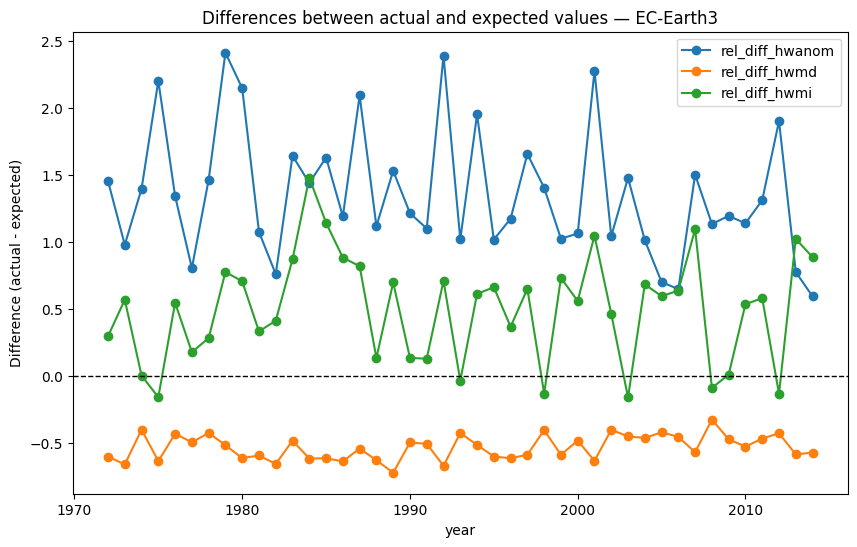

In [63]:
plot_differences("EC-Earth3", yearly_checks)

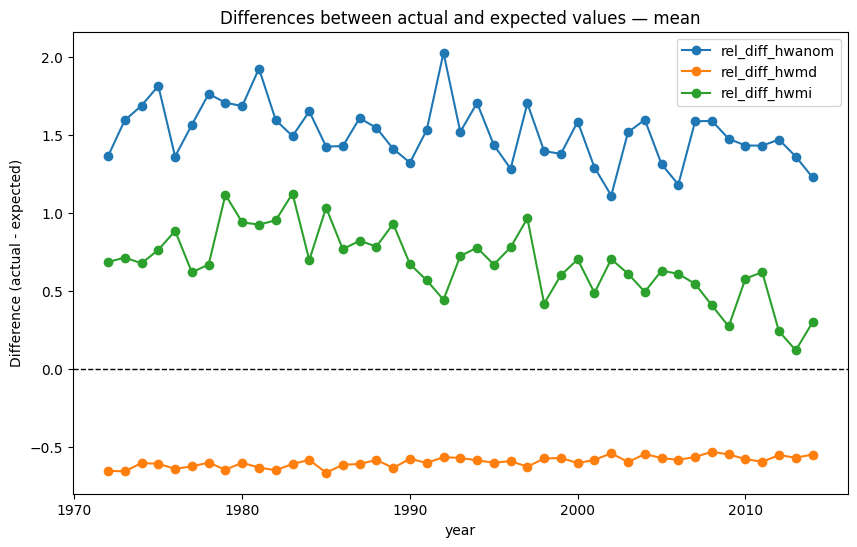

In [64]:
# Example: yearly
plot_differences("mean", yearly_checks)


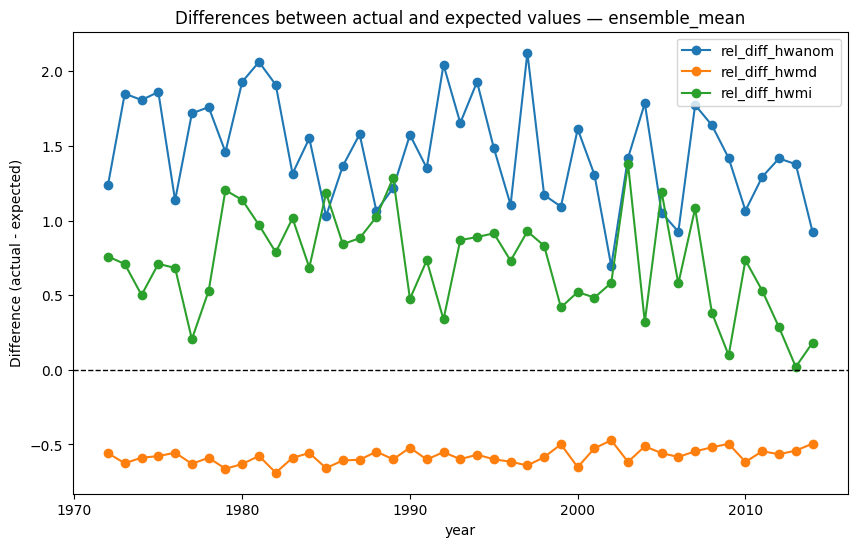

In [65]:
# Example: yearly
plot_differences("ensemble_mean", yearly_checks)


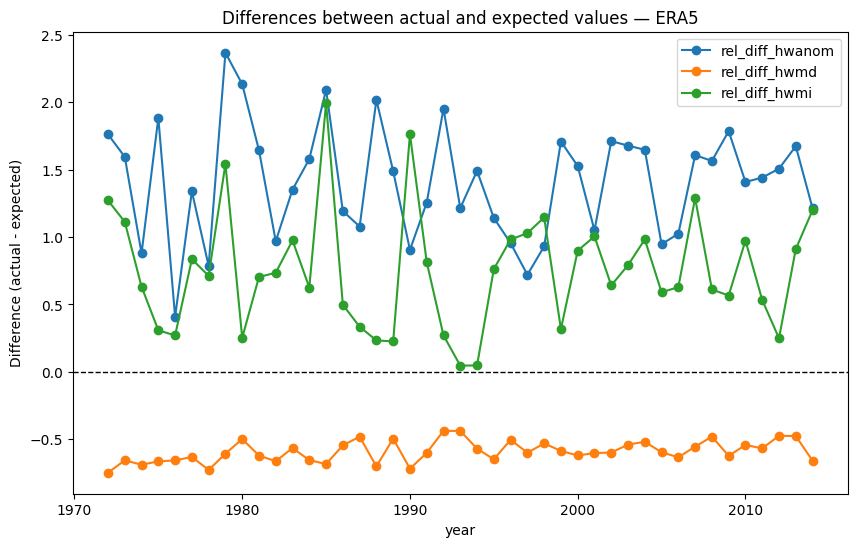

In [66]:
plot_differences("ERA5", yearly_checks)
